# Evaluation of ion suppression correction

In this notebook, I explore different measures to quantify the effect of correcting SpaceM ion intensity data for partial pixel-cell overlap.
 

In [1]:
import platform
import os
import multiprocessing
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from src.correction import *
from src.evaluation import intermixing
from sklearn.cluster import KMeans
import re
import outer_spacem as osm


In [2]:
if platform.system() == "Darwin":
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'

condition_name = 'dataset_3'

In [3]:
adata = ad.read(os.path.join(target_path, "gen_batch_sm_matrix.h5ad"))
adata_cor = ad.read(os.path.join(target_path, "corrected_batch_sm_matrix.h5ad"))

In [4]:
def preprocess(adata):
    sc.pp.filter_cells(adata, min_genes=10)
    sc.pp.filter_genes(adata, min_cells=200)
    adata.raw = adata
    # sc.pp.scale(adata)
    sc.pp.normalize_total(adata, target_sum=None)
    sc.pp.log1p(adata)

preprocess(adata)
preprocess(adata_cor)


print(adata.shape)
print(adata_cor.shape)


(14455, 959)
(14455, 959)


In [5]:
included_molecules = adata.var_names.intersection(adata_cor.var_names)
included_cells = adata.obs_names.intersection(adata_cor.obs_names)
#included_cells = included_cells.intersection(adata.obs[adata.obs[condition_name].isin(['NaiveWT', 'TMDsM', 'TMDdM', 'TMDtM', 'TMDCD95KO', 'TMDCD95WT'])].index)
def subset_molecules(adata):
    
    return adata[included_cells, included_molecules]

adata = subset_molecules(adata)
adata_cor = subset_molecules(adata_cor)

print(adata.shape)
print(adata_cor.shape)

(14455, 959)
(14455, 959)


In [6]:
# some conditions have types. they are manually corrected
print(adata.obs[condition_name].value_counts())
adata.obs[condition_name] = adata.obs[condition_name].replace(['TMDCD96KO', 'TMDd\sM'], ['TMDCD95KO', 'TMDsM'])
adata_cor.obs[condition_name] = adata_cor.obs[condition_name].replace(['TMDCD96KO', 'TMDd\sM'], ['TMDCD95KO', 'TMDsM'])
print(adata.obs[condition_name].value_counts())

TMDdM        3427
NaiveWT      3142
TMDCD95WT    2448
TMDtM        1797
TMDsM        1652
TMDCD95KO    1198
TMDd\sM       398
TMDCD96KO     393
Name: dataset_3, dtype: int64


/tmp/ipykernel_4549/3595141124.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[condition_name] = adata.obs[condition_name].replace(['TMDCD96KO', 'TMDd\sM'], ['TMDCD95KO', 'TMDsM'])
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/tmp/ipykernel_4549/3595141124.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cor.obs[condition_name] = adata_cor.obs[condition_name].replace(['TMDCD96KO', 'TMDd\sM'], ['TMDCD95KO', 'TMDsM'])


TMDdM        3427
NaiveWT      3142
TMDCD95WT    2448
TMDsM        2050
TMDtM        1797
TMDCD95KO    1591
Name: dataset_3, dtype: int64


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [19]:
adata.obs['correction'] = 'uncorrected'
adata_cor.obs['correction'] = 'ISM correction'

In [82]:
assert not any(pd.Series(np.array((adata.to_df() == 0) & (adata_cor.to_df()!= 0)).flatten()))

In [54]:
from bioinfokit import visuz
def analyse_corrected_metabolites(adata,
    adata_cor,
    top_ions = 5,
    volcano_plot = True,
    pair_plot = True,
    top_plot = True,
    to_metenrichr = True
):
    conc_adata = ad.concat({'uncorrected': adata, 'ISM correction': adata_cor}, label='correction', index_unique='_', merge='same')
    
    sc.tl.rank_genes_groups(adata=conc_adata, groupby='correction', use_raw=True, method='wilcoxon')
    all_ions_dea = sc.get.rank_genes_groups_df(conc_adata, group='ISM correction')

    adata_cor.var['names'] = adata_cor.var.index
    impact_ions = pd.merge(all_ions_dea, adata_cor.var[['names', 'correction_using_ion_pool', 'correction_n_iterations', 'correction_n_datapoints', 'mean_correction_quantreg_slope']], on='names', how='left')
    impact_ions = impact_ions.sort_values(by='scores')
    impact_ions['logfoldchanges'] = impact_ions['logfoldchanges'].replace(-np.Inf, -1000)

    impact_ions['significant'] = (impact_ions['pvals'] < 0.001) & (impact_ions['scores'] < -2)
    sign_impact_ions = impact_ions[impact_ions['significant'] == True]
    
    print('Of %1d ions, %1d are significantly altered by ion suppression correction (p < 1e-3, DEA score < -2).'%(len(impact_ions), len(sign_impact_ions)))
    if volcano_plot:
        print('volcano plot of changed intensities')
        volcano_df = impact_ions
        volcano_df['-log pval'] = -np.log10(volcano_df['pvals'])
        fig, ax = plt.subplots(1,2)
        sns.scatterplot(volcano_df, x='logfoldchanges', y='-log pval', ax=ax[0], hue='significant')
        sns.scatterplot(volcano_df, x='scores', y='-log pval', ax=ax[1], hue='significant')
        ax[0].set_title('Intensity LFC by ion suppression correction')
        ax[1].set_title('Corresponding scores')
        fig.set_figwidth(12)
    
    conc_adata_raw = conc_adata.copy()
    conc_adata_raw.obs['cell'] = [re.sub('_[a-zA-Z ]+$', '', i) for i in conc_adata_raw.obs.index]
    conc_adata_raw.X = conc_adata_raw.raw.X
    changed_ions_df = sc.get.obs_df(conc_adata_raw, keys=(['correction', condition_name, 'cell', 'well']+list(conc_adata.var_names)))
    plot_df = changed_ions_df.melt(id_vars=['correction', condition_name, 'cell', 'well'], var_name='ion').pivot(index=['ion', condition_name, 'cell', 'well'], columns='correction', values='value')
    plot_df.reset_index(inplace=True)
    plot_df = plot_df[plot_df.uncorrected > 0]
    
    if pair_plot:
        def correlate_ions(ion):
            return plot_df[plot_df.ion == ion].corr(numeric_only = True)['uncorrected']['ISM correction']
        print('associations between measures')
        impact_ions['pearson'] = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(correlate_ions)(ion) for ion in tqdm(impact_ions['names']))
        sns.pairplot(impact_ions[['scores', 'logfoldchanges', 'mean_correction_quantreg_slope', 'pearson']])
     
    if top_plot:
        print('top most and least corrected ions')
        ions_corr = list(impact_ions['names'].head(top_ions))
        ions_uncorr = list(impact_ions['names'].tail(top_ions))
        ions = ions_corr + ions_uncorr

        plot_df['group'] = ['strongly corr' if (ion in ions_corr) else 'hardly corr' if (ion in ions_uncorr) else 'other' for ion in plot_df['ion'] ]

        slopes = [adata_cor.var.loc[ion, 'correction_quantreg_slope'] for ion in ions]
        intersects = [adata_cor.var.loc[ion, 'correction_quantreg_intersect'] for ion in ions]
        pearson = [plot_df[plot_df.ion == ion].corr(numeric_only=True)['uncorrected']['ISM correction'] for ion in ions]
        scores = [float(impact_ions.loc[impact_ions.names == ion, 'scores']) for ion in ions]
        grid = sns.FacetGrid(plot_df, col='ion', hue='group', col_wrap=5, sharex=False, sharey=False, col_order=ions, palette='cividis')
        grid.map(sns.scatterplot, 'uncorrected', 'ISM correction').add_legend()
        grid.set(aspect = 1)
        for i, ax in enumerate(grid.axes.flat): 
            lim = max([ax.get_xlim()[1], ax.get_ylim()[1]])
            # ax.set_xlim(0, lim)
            # ax.set_ylim(0, lim)f
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.axline((0,0), (1,1))
            ax.set_title(ax.get_title() + '\nquantreg slope = %1.3f\nintersect = %1.3f\npearson r = %1.5f\nscores = %1.2f'%(slopes[i], intersects[i], pearson[i], scores[i]))

    if to_metenrichr:
        subset_adata = conc_adata_raw.copy()
        df = subset_adata.to_df()
        # compress data by rounding
        significant_figures = int(df.shape[0] * df.shape[1] / 6e6)
        df = df.applymap(lambda x: 0 if x == 0 else round(x, significant_figures - int(np.floor(np.log10(np.abs(x))))))
        df.to_csv(os.path.join(target_path, 'metenrichr_matrix.csv'))

        metadata = pd.DataFrame(subset_adata.obs['correction'])
        metadata['correction'].name = 'condition'
        metadata.to_csv(os.path.join(target_path, 'metenrichr_metadata.csv'))
        
    

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.

Of 959 ions, 353 are significantly altered by ion suppression correction (p < 1e-3, DEA score < -2).
volcano plot of changed intensities
associations between measures



100%|██████████| 959/959 [04:16<00:00,  3.73it/s]


top most and least corrected ions


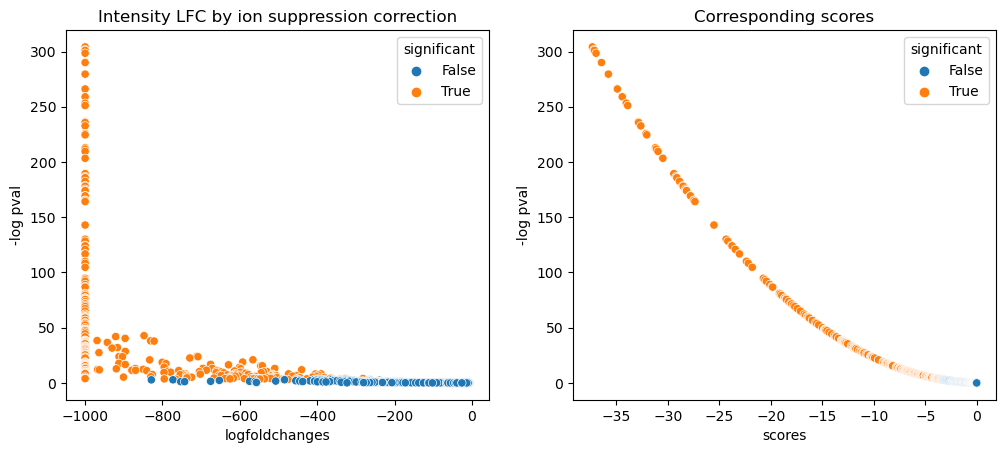

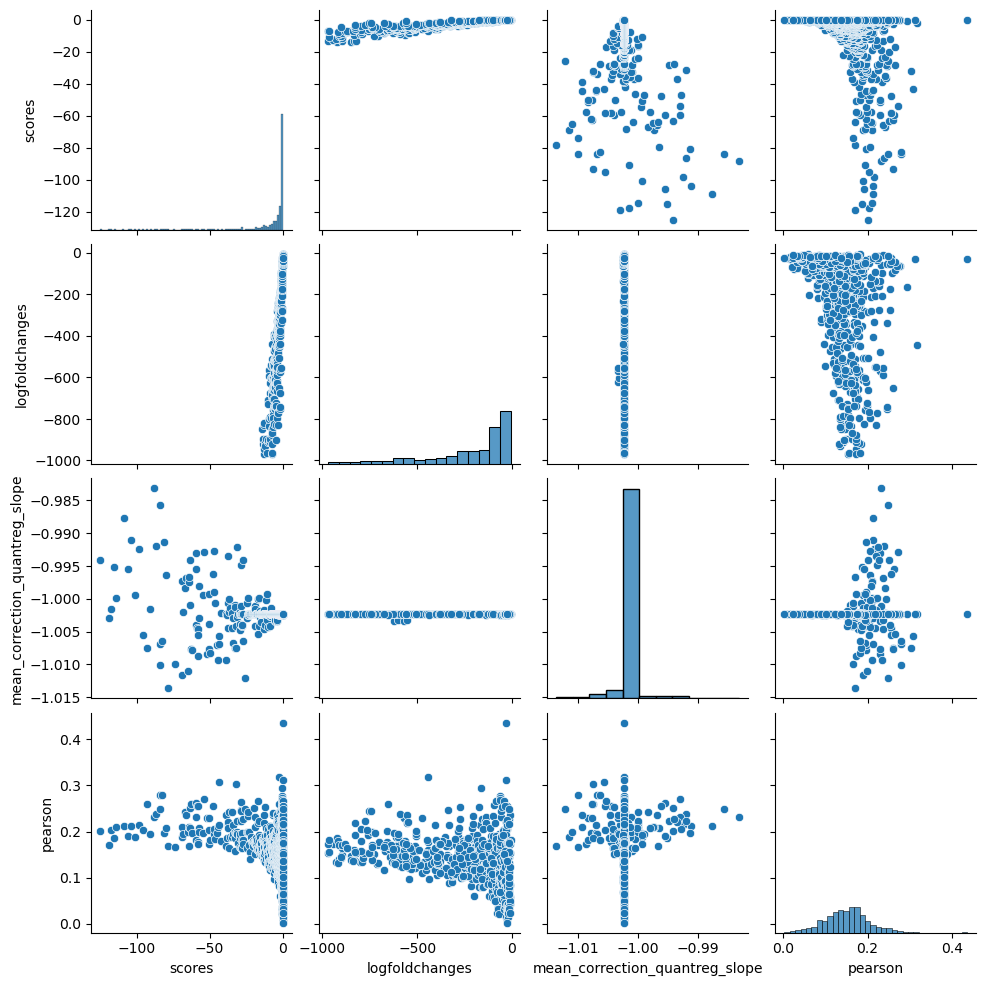

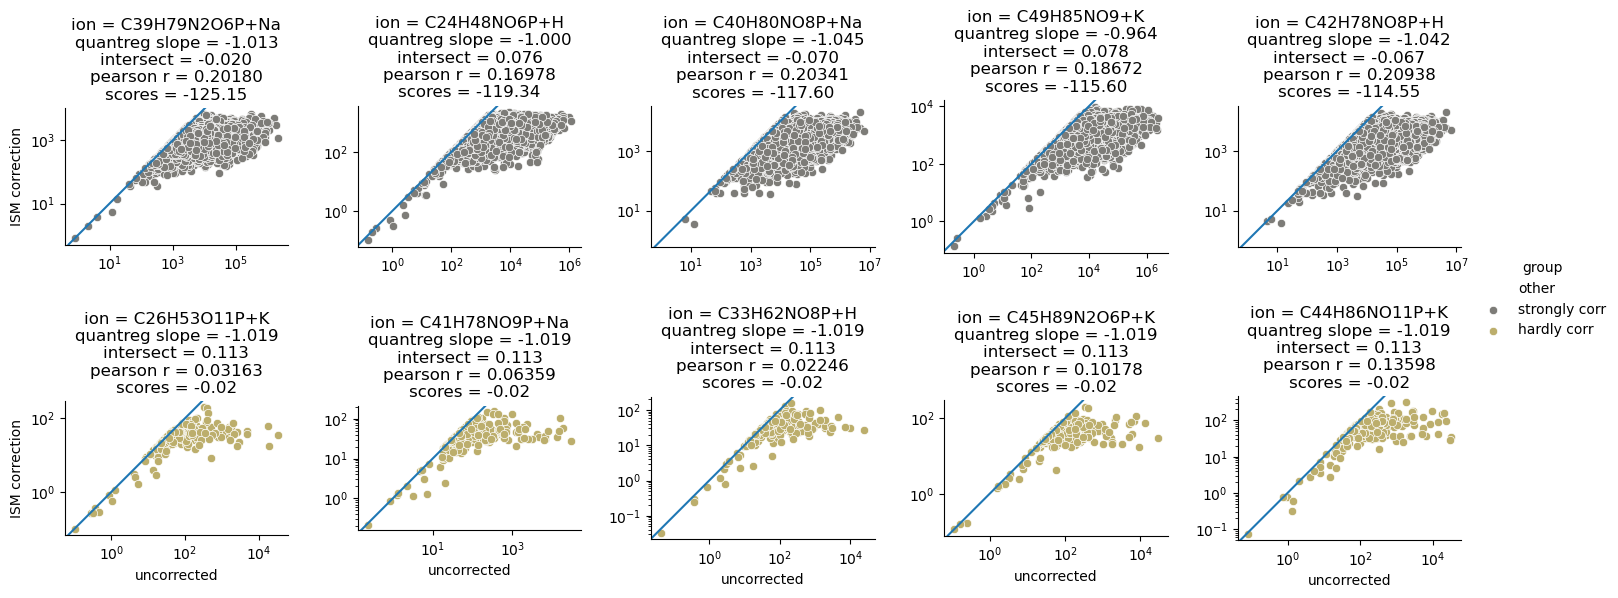

In [56]:
analyse_corrected_metabolites(adata, adata_cor)

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


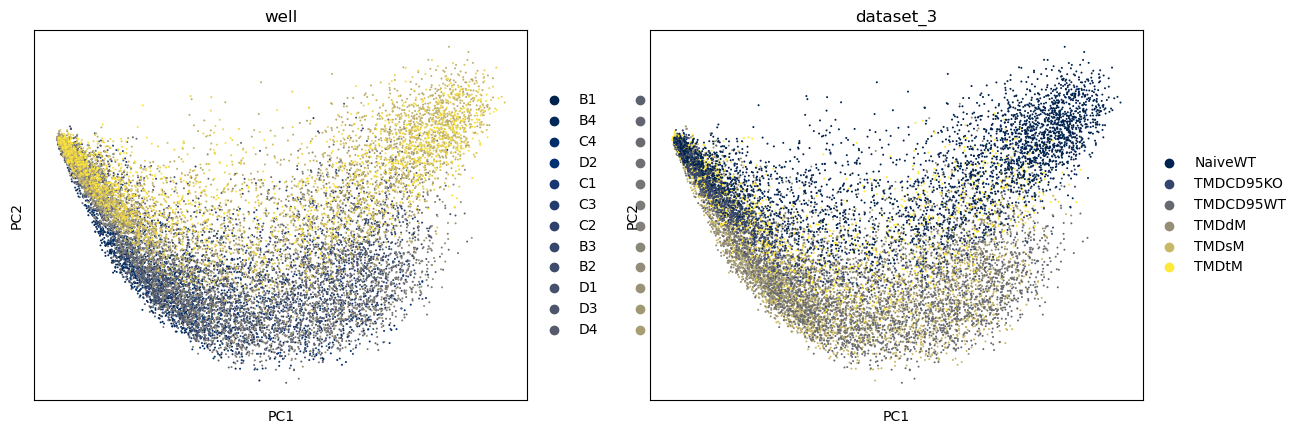

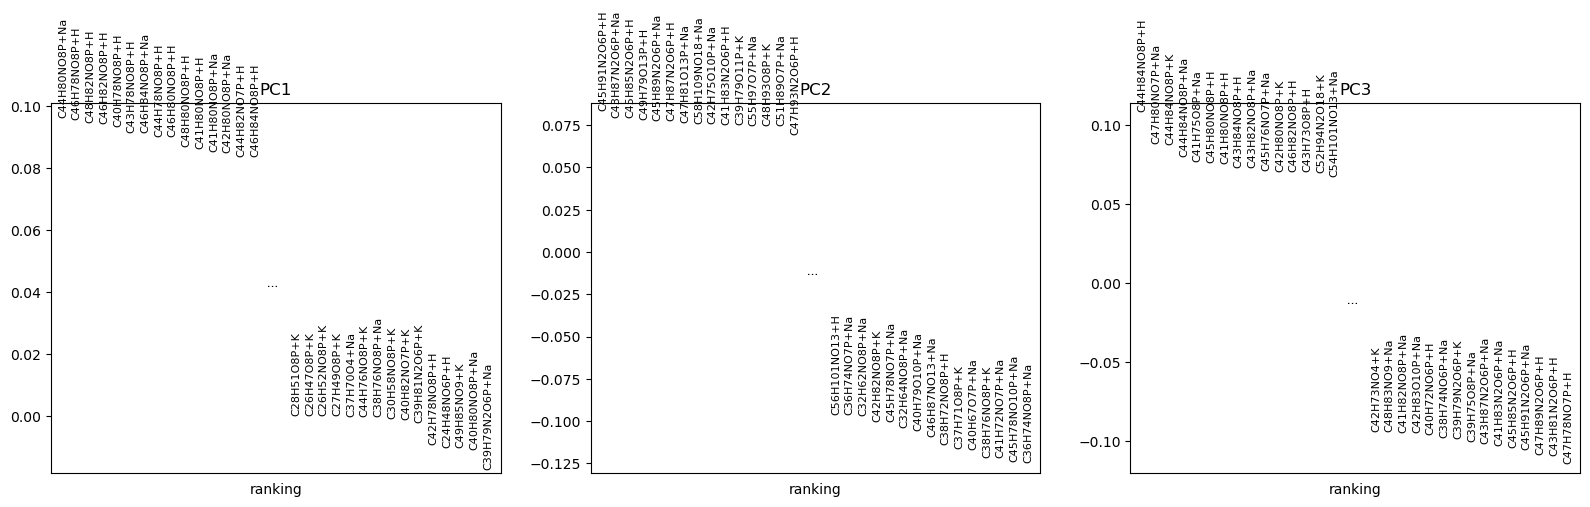

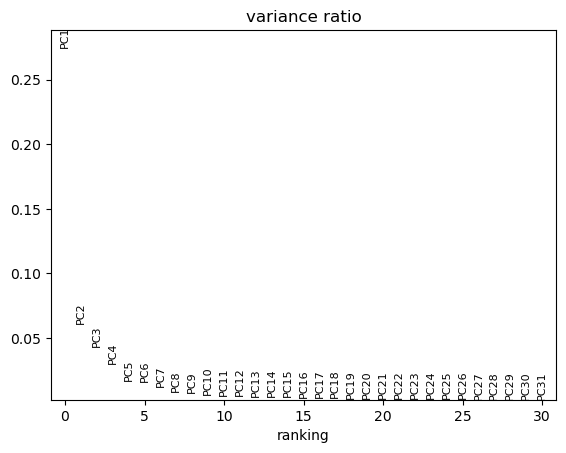

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


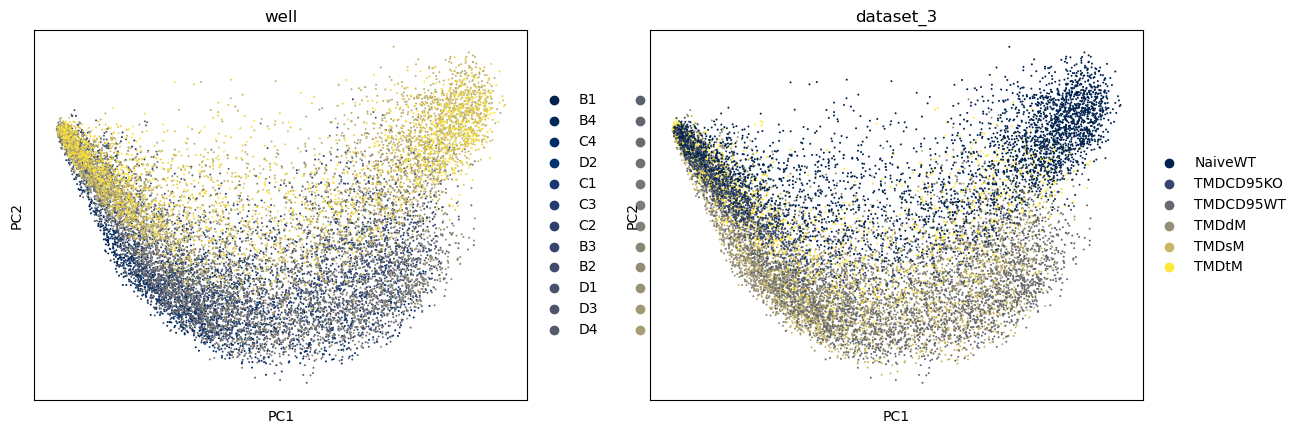

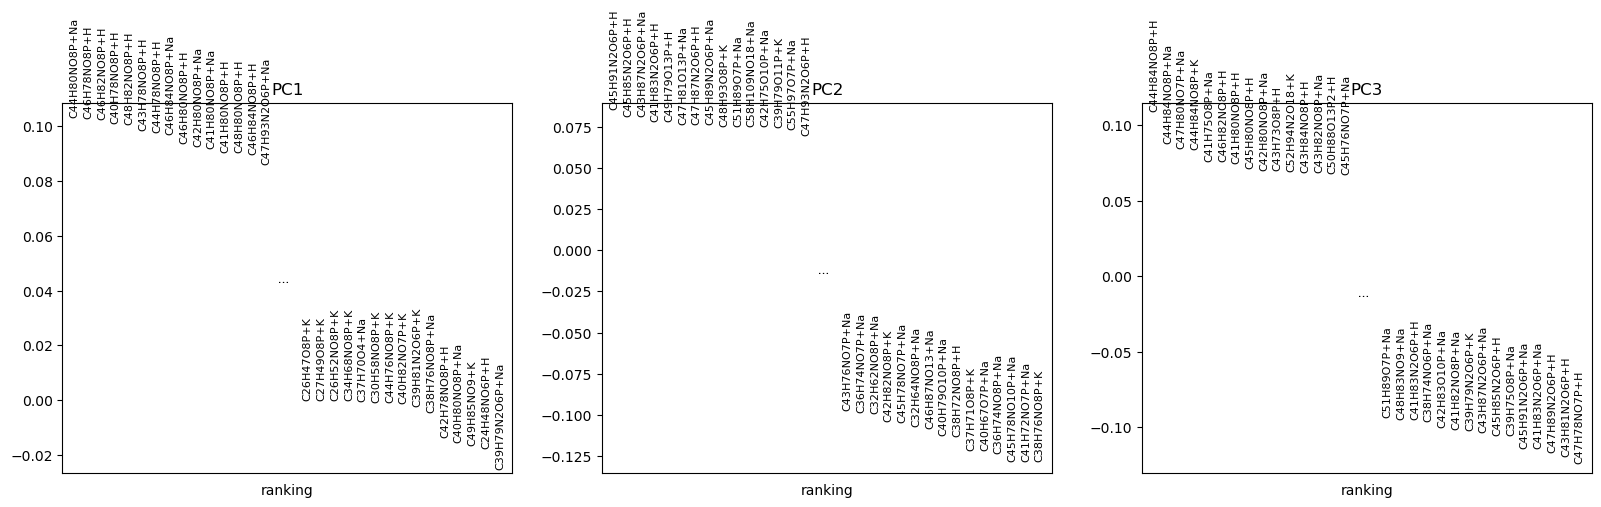

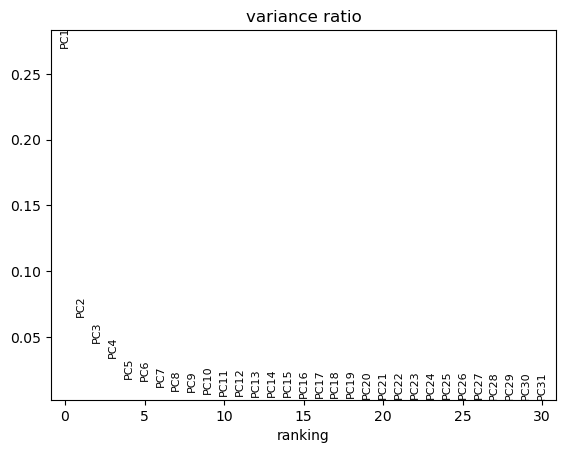

In [34]:
def dimred_pca(adata):
    sc.pp.pca(adata)
    sc.pl.pca_overview(adata, color=['well', condition_name], palette='cividis')

dimred_pca(adata)
dimred_pca(adata_cor)

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


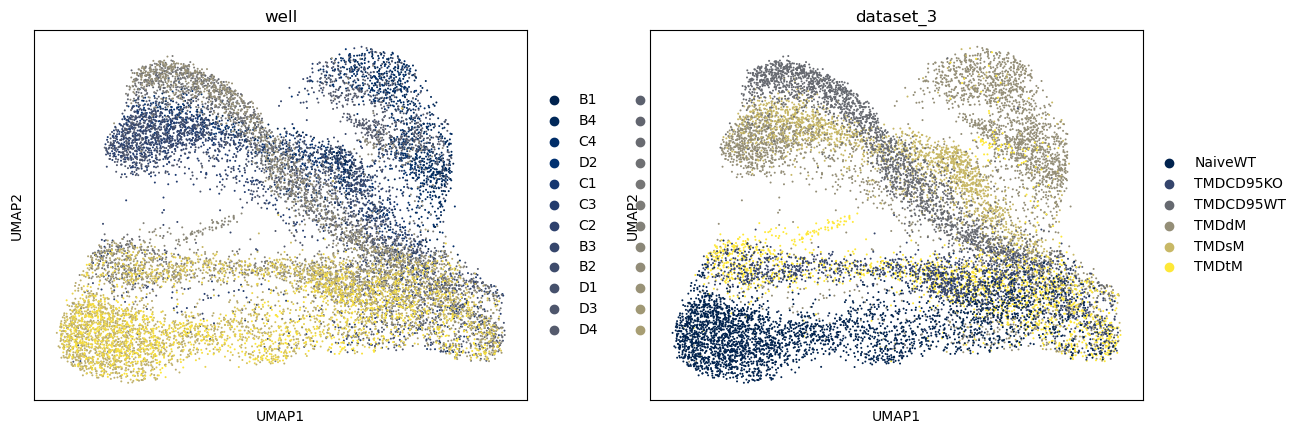

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


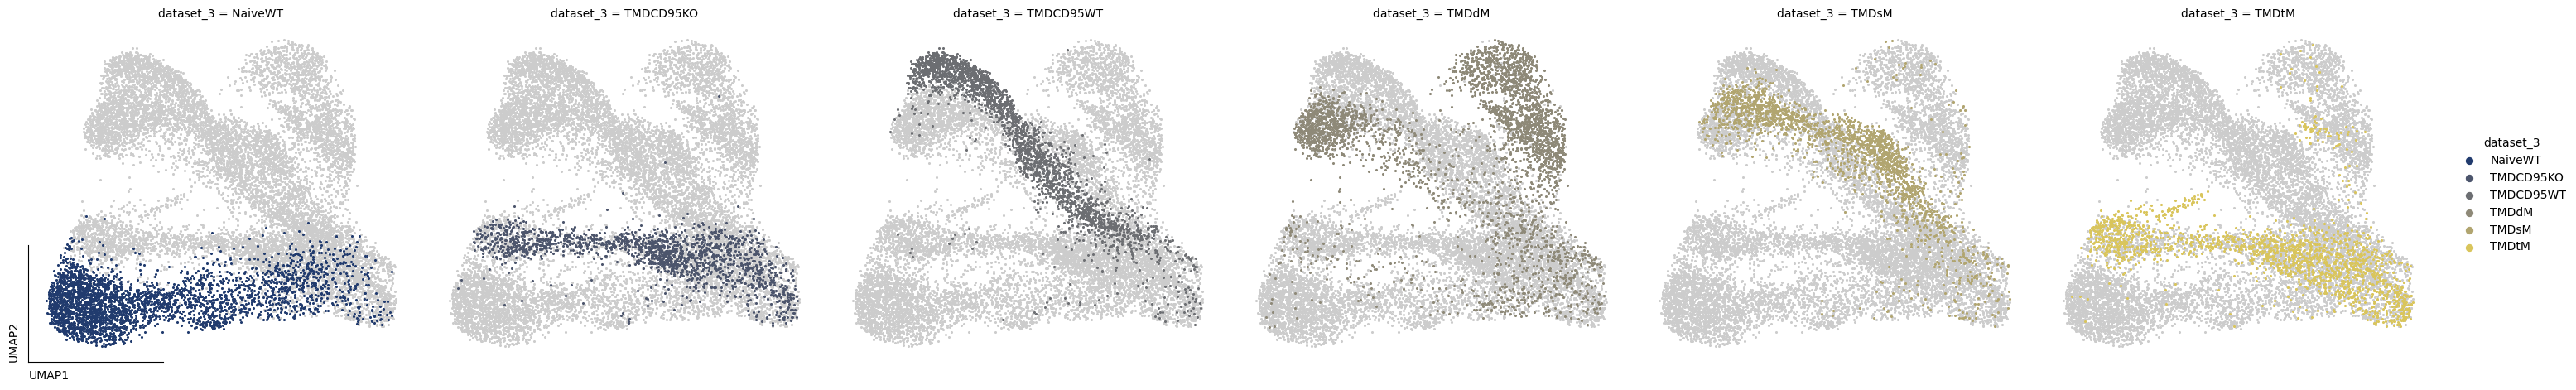

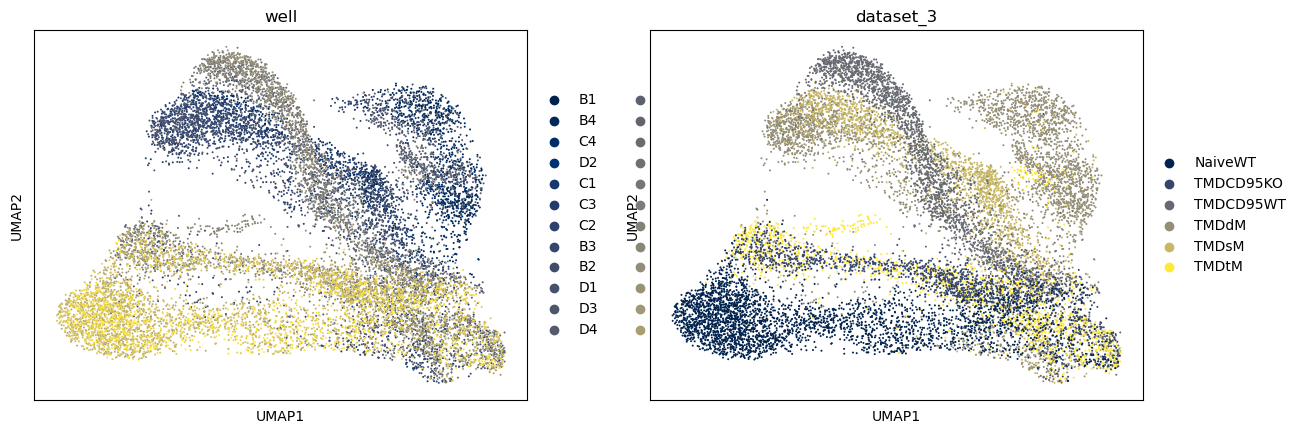

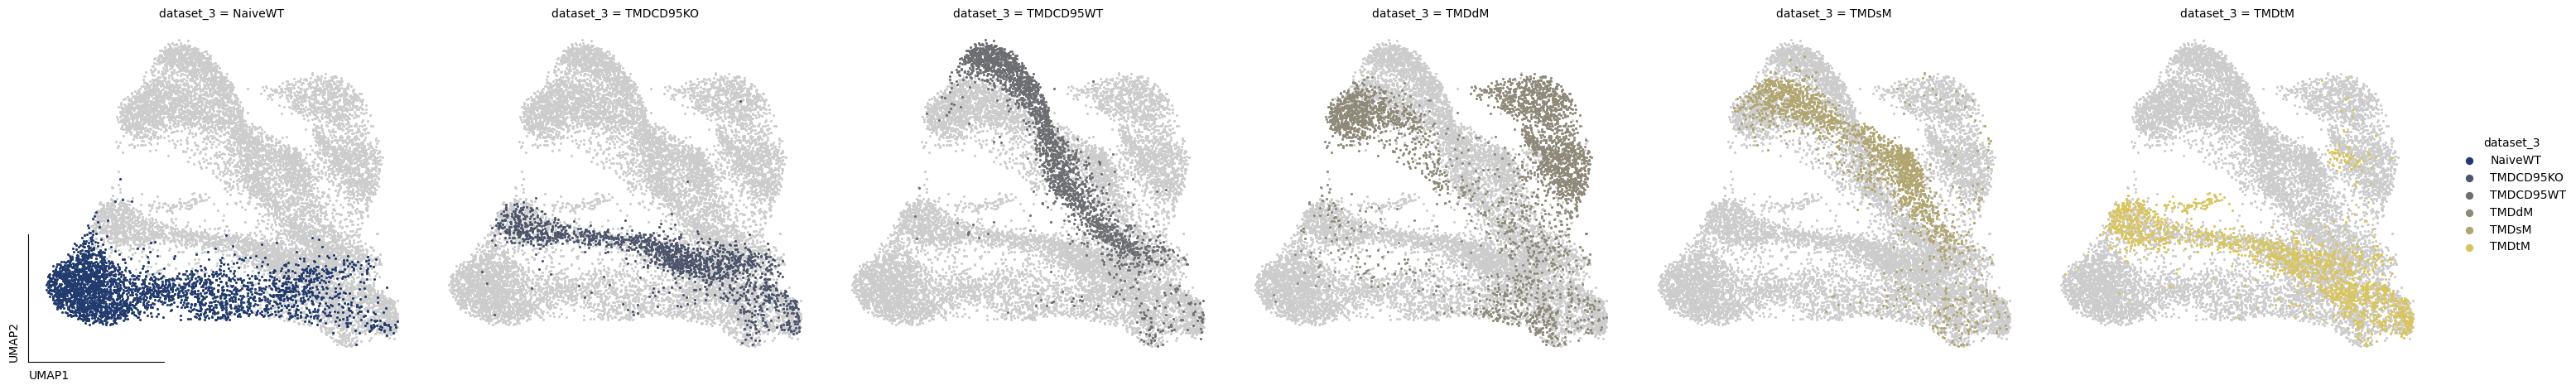

In [39]:
def dimred_umap(adata, min_dist = 0.5):
    sc.pp.neighbors(adata, n_neighbors=50, metric='cosine')
    sc.tl.umap(adata, min_dist=min_dist, spread=1.0, random_state=1, n_components=2)
    sc.pl.umap(adata, color=['well', condition_name], palette='cividis')
    f = osm.pl.highlight_scatterplot(
        data = adata,
        obsm_key = "X_umap",
        hue = condition_name,
        col = condition_name,
        palette = "cividis",
        trim_axes=True,
        height = 5,
        scatter_kwargs = dict(s=5)
    )

    f.add_legend(markerscale=3)


dimred_umap(adata)
dimred_umap(adata_cor)


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


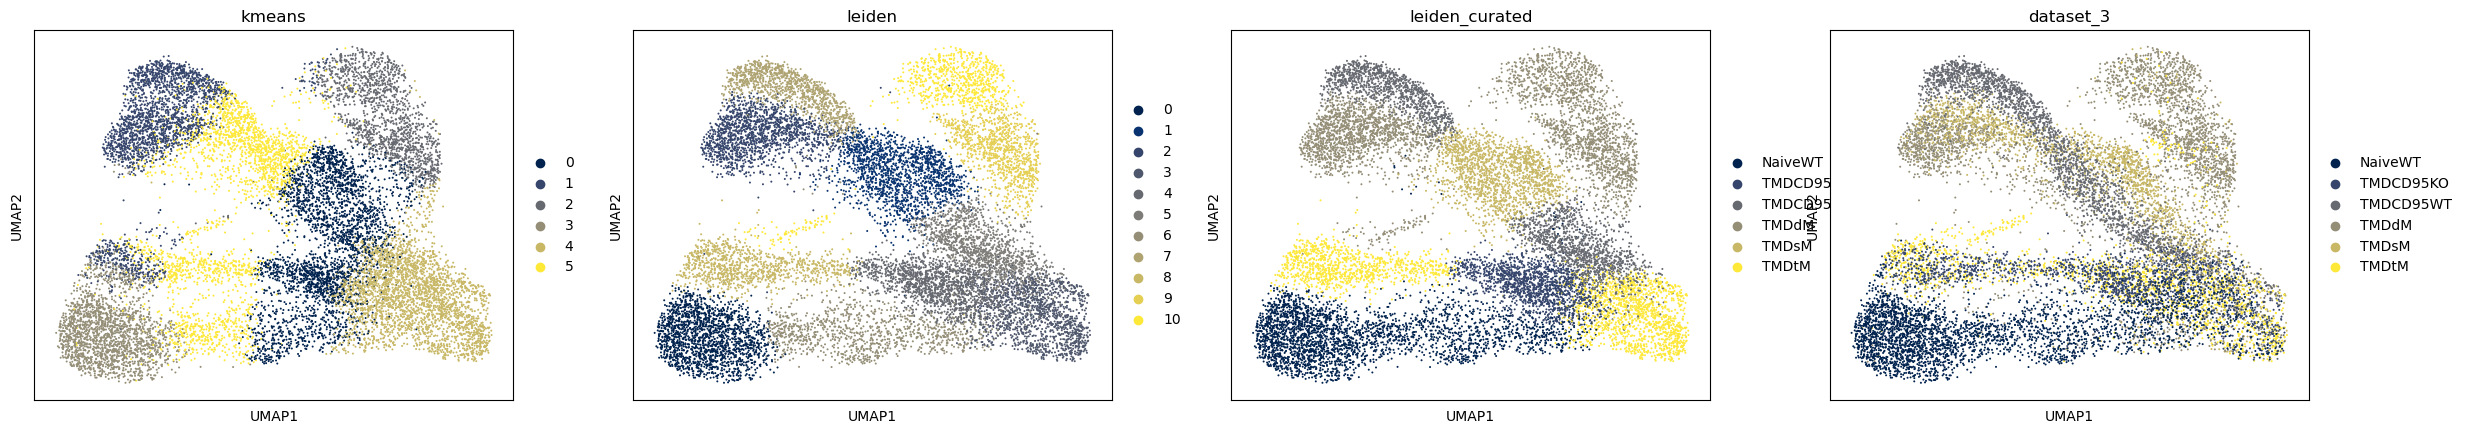

Curated leiden acccuracy score: 0.6275
KMeans completeness score: 0.2199
KMeans silhouette coefficient: 0.0825


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


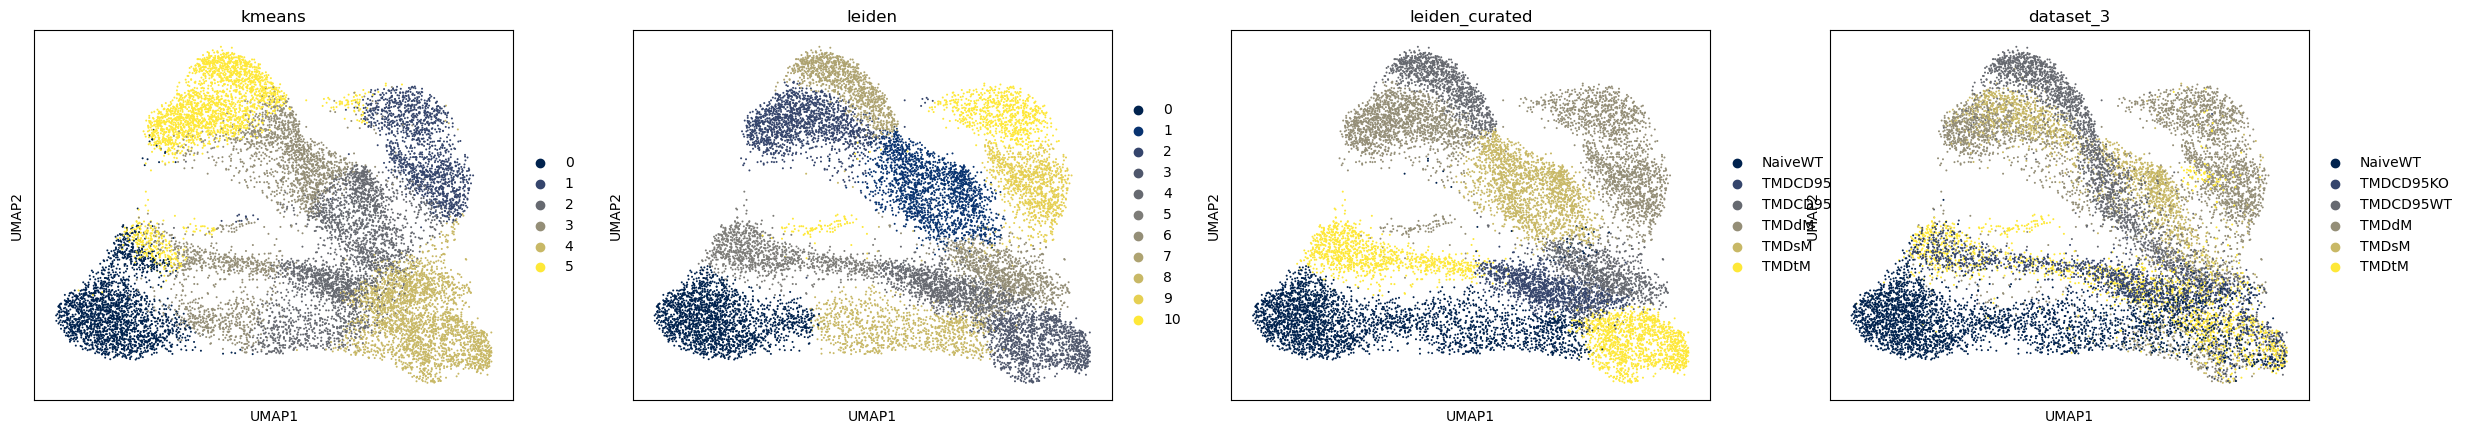

Curated leiden acccuracy score: 0.6377
KMeans completeness score: 0.2255
KMeans silhouette coefficient: 0.0887


In [33]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import accuracy_score, silhouette_score

def kmeans_clust(adata):
    n_clusters = len(adata.obs[condition_name].value_counts())
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = kmeans.labels_.astype(str)

    sc.tl.leiden(adata, resolution=1)

    leiden = np.array(adata.obs['leiden'].values)
    leiden_curated = np.copy(leiden)
    fc = np.array(adata.obs[condition_name].values)
    for cluster in np.unique(leiden):
        labels, counts = np.unique(fc[leiden == cluster], return_counts=True)
        leiden_curated[leiden == cluster] = str(labels[counts == np.max(counts)][0])
    adata.obs['leiden_curated'] = leiden_curated

    sc.pl.umap(adata, color=['kmeans', 'leiden', 'leiden_curated', condition_name], palette='cividis')
    # print('Leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs[condition_name].replace(['HeLa', 'NIH3T3'], ['0', '1']), y_pred = adata.obs['leiden']))
    print('Curated leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs[condition_name], y_pred = adata.obs['leiden_curated']))
    print('KMeans completeness score: %1.4f' % completeness_score(adata.obs[condition_name], adata.obs['kmeans']))
    print('KMeans silhouette coefficient: %1.4f' % silhouette_score(adata.X, adata.obs['kmeans']))

kmeans_clust(adata)
kmeans_clust(adata_cor)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def LDA(adata):
    predictors = adata.X
    result = adata.obs[condition_name]
    model = LinearDiscriminantAnalysis()
    model.fit(predictors, result)  

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, predictors, result, scoring='accuracy', cv=cv, n_jobs=multiprocessing.cpu_count())
    
    adata.obs['lda'] = model.predict(adata.X)
    sc.pl.umap(adata, color=[condition_name, 'lda'], palette='cividis')
    print("LDA accuracy after 10-fold cross-validation: %1.4f (±%1.4f)" % (np.mean(scores), np.std(scores)))  


LDA(adata) 
LDA(adata_cor) 

X_pca
X_umap


mean        sd  rel_neighborhood
X_pca_uncorrected     10  0.284289  0.277421          0.091837
X_pca_ISM correction  10  0.272777  0.273377          0.091837
X_umap_uncorrected    10  0.370811  0.284778          0.091837
X_umap_ISM correction 10  0.351961  0.284905          0.091837

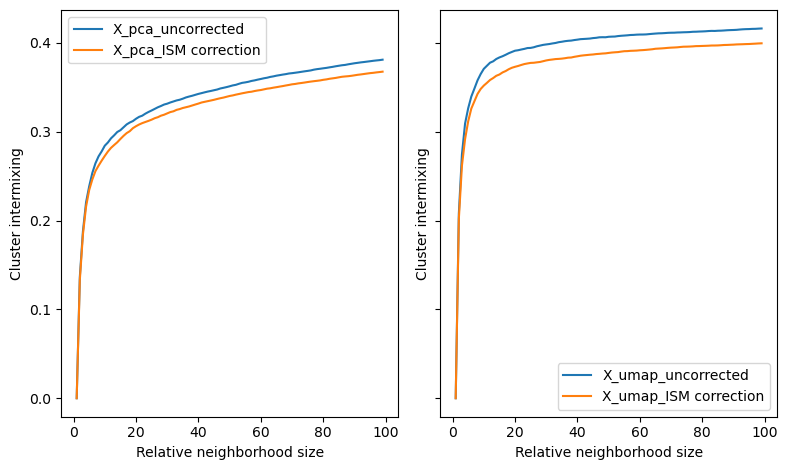

In [40]:
src.evaluation.intermixing({'uncorrected': adata, 'ISM correction': adata_cor}, condition_name = condition_name, measures = ['X_pca', 'X_umap'])